<a href="https://colab.research.google.com/github/LucasLuiselli93/datos/blob/main/Car_Insurances_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
El conjunto de datos consta de las siguientes columnas:

age_of_driver: La edad del conductor.
car_age: La edad del coche.
región: La región donde se encuentra el conductor (Urbana, Rural, Suburbana).
number_of_claims: el número de reclamaciones realizadas.

Entonces, el objetivo de esta tarea de modelado de seguros de automóviles será predecir la frecuencia de las reclamaciones de seguros realizadas por los conductores.
```



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# cargar data
insurance_data = pd.read_csv("cars.csv")

# Mostrar los primeros registros del dataset
print(insurance_data.head())

,age_of_driver,car_age,region,number_of_claims
0,30,7,Urban,0
1,33,10,Rural,2
2,39,11,Suburban,1
3,18,12,Urban,0
4,21,8,Urban,0
...,...,...,...,...
995,46,0,Rural,0
996,26,1,Suburban,0
997,36,1,Rural,1
998,43,8,Urban,0


In [ ]:
# Resumir estadisticas
summary_stats = insurance_data.describe(include='all')

# Chequear valores missing
missing_values = insurance_data.isnull().sum()


print(summary_stats)


        age_of_driver      car_age region  number_of_claims
count     1000.000000  1000.000000   1000       1000.000000
unique            NaN          NaN      3               NaN
top               NaN          NaN  Rural               NaN
freq              NaN          NaN    343               NaN
mean        33.112000     6.673000    NaN          0.675000
std          9.253598     4.377583    NaN          0.822223
min         18.000000     0.000000    NaN          0.000000
25%         25.000000     3.000000    NaN          0.000000
50%         33.000000     6.000000    NaN          0.000000
75%         41.000000    11.000000    NaN          1.000000
max         49.000000    14.000000    NaN          5.000000


In [ ]:
print(missing_values)

age_of_driver       0
car_age             0
region              0
number_of_claims    0
dtype: int64


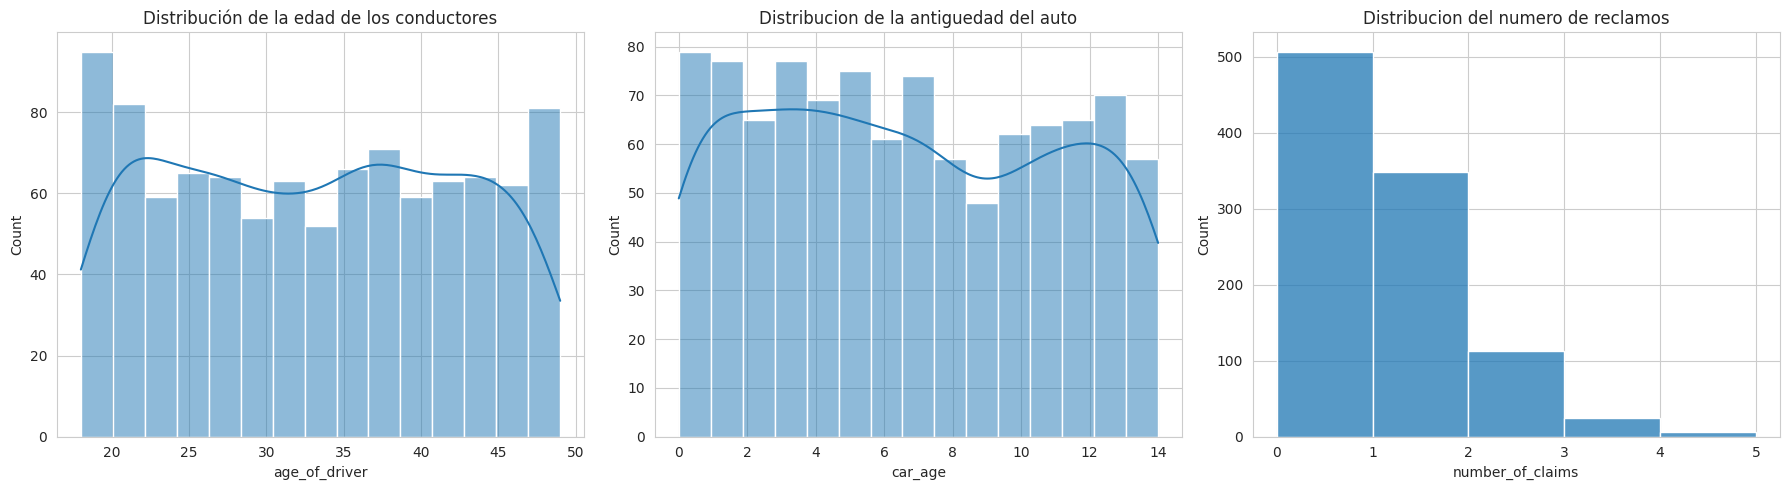

In [ ]:
# Graficos
sns.set_style("whitegrid")

# Graficar variables numericas
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(insurance_data['age_of_driver'], kde=True, bins=15, ax=ax[0])
ax[0].set_title('Distribución de la edad de los conductores')

sns.histplot(insurance_data['car_age'], kde=True, bins=15, ax=ax[1])
ax[1].set_title('Distribucion de la antiguedad del auto')

sns.histplot(insurance_data['number_of_claims'], kde=False, bins=range(6), ax=ax[2])
ax[2].set_title('Distribucion del numero de reclamos')

plt.tight_layout()
plt.show()

Observaciones:

**Age of Driver**: Distribución normal principalmente centrada en bajas edades.

**Car Age**: distribucion normal con leve asimetria por derecha.

**Number of Claims**: mayoria de conductores tiene 0 reclamos, cosa que puede ver en la distribucion muy asimetrica por derecha.

In [ ]:
from sklearn.model_selection import train_test_split

# Codificación One-Hot para la Variable 'region'
insurance_data_encoded = pd.get_dummies(insurance_data, columns=['region'], drop_first=True)

# Dividir en training and testing el dataset
train, test = train_test_split(insurance_data_encoded, test_size=0.2, random_state=42)
train = train.astype({'region_Suburban': int, 'region_Urban': int})
test = test.astype({'region_Suburban': int, 'region_Urban': int})

print(train.head())

     age_of_driver  car_age  number_of_claims  region_Suburban  region_Urban
29              26       13                 1                0             0
535             42        9                 2                1             0
695             44        8                 1                0             0
557             41        3                 1                1             0
836             31       12                 0                0             1


La variable **'region'** se ha codificado en "one hot", lo que da como resultado dos nuevas variables region_Suburban y region_Urban (siendo región_Rural la categoría de referencia implícitamente). Los datos también se dividieron en conjuntos de entrenamiento (80%) y pruebas (20%).


Para modelar la frecuencia de eventos, especialmente para datos de recuento como el número de reclamaciones, normalmente se utiliza la regresión binomial negativa o de Poisson. La elección entre ellos suele depender de la varianza de los datos del recuento:

**Regresión de Poisson**: asume que la media y la varianza de los datos del recuento son iguales. Adecuado cuando los datos no presentan mucha dispersión.

**Regresión binomial negativa**: más flexible, puede manejar la sobredispersión (varianza mayor que la media) en los datos de recuento.

In [ ]:
# Preparamos los datos para regresion de poisson
X_train = train.drop('number_of_claims', axis=1)
y_train = train['number_of_claims']

# Agregar una columna de constante. Necesario para estimar correctamente el intercepto del modelo de regresión
X_train_const = sm.add_constant(X_train)

# Construir modelo de Regresion de Poisson
poisson_glm = sm.GLM(y_train, X_train_const, family=sm.families.Poisson()).fit()

# Mostrar resumen del modelo
poisson_glm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       number_of_claims   No. Observations:                  800
Model:                            GLM   Df Residuals:                      795
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -845.44
Date:                Tue, 04 Jun 2024   Deviance:                       829.41
Time:                        23:29:44   Pearson chi2:                     770.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02749
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0906      0.181      0.502      0.616      -0.263       0.444
age_of_driver      -0.0205      0.005     -4.321      0.000      -0.030      -0.011
car_age             0.0152      0.010      1.539      0.124      -0.004       0.035
region_Suburban     0.0799      0.106      0.755      0.450      -0.127       0.287
region_Urban        0.0861      0.108      0.794      0.427      -0.126       0.298
===================================================================================
"""

El pseudo R-cuadrado es una medida análoga al R-cuadrado en la regresión lineal, pero para modelos de regresión con variables dependientes de tipo discreto o de conteo. En este caso, el valor de 0.0275 indica que el modelo tiene un poder explicativo relativamente bajo.

**Coeficientes**

**age_of_driver**: El coeficiente negativo (-0.0205) indica que, a mayor edad del conductor, se espera un menor número de reclamaciones.

**car_age**: El coeficiente positivo (0.0152) sugiere que, a mayor edad del automóvil, se espera un mayor número de reclamaciones, aunque en este caso no es estadísticamente significativo (p-valor = 0.124).

region_Suburban y region_Urban: Estos coeficientes positivos (0.0799 y 0.0861, respectivamente) indican que, en comparación con la categoría base (posiblemente 'Rural'), se espera un mayor número de reclamaciones en las regiones suburbanas y urbanas. Sin embargo, estos coeficientes tampoco son estadísticamente significativos (p-valor > 0.05).


**Significancia estadística**: Los p-valores indican que la única variable estadísticamente significativa en el modelo es age_of_driver. Las demás variables no son significativas al nivel de significancia estándar de 0.05.

**En resumen**, según este modelo, **la edad del conductor parece ser el único factor que influye significativamente en el número de reclamaciones, con un efecto negativo**. Las demás variables, como la edad del automóvil y la región, no muestran un efecto significativo en este conjunto de datos.